<b> <h1> <font color='darkblue'> MOVIE SENTIMENT ANALYSIS- ROTTEN TOMATOES </font> </h1> </b>

In [ ]:
import pandas as pd 
import numpy as np
import numpy as numpy
import bs4
import requests   # Webscrapping tool
import matplotlib.pyplot as plt
import seaborn as sms
from wordcloud import WordCloud # wordcloud 
import re # regular expression
import plotly.express as px
from gensim.parsing.preprocessing import PorterStemmer, remove_stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,f1_score
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.svm import SVC
from gensim.models import KeyedVectors,word2vec
from keras.preprocessing.text import Tokenizer  # this will do tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Problem Statment

- Sentiment analysis is one of the most popular applications of natural language processing and text analytics. Typically, sentiment analysis seems to work best on subjective text, where group of people or individual express their opinions, feelings, and their mood. From a real-world industry, sentiment analysis is widely used to analyse feedback surveys, social media data, and reviews for movies, places etc.
The main objective of this project is to predict the sentiment of reviews for several movie reviews obtained from the Rotten Tomatoes movie review website by scrapping. The main task is to label the reviews on a scale of three values: negative, neutral and positive and build a binary classification model using positive and negative labels.

# Loading the Dataset

In [2]:
df_movie = pd.read_csv('movie_details_final.csv')  # dataset with all the movie details
df_movie.head()

,Director,Genre,Movie_Summary,Original Language,Rating,Release Date,Title
0,Antoine Fuqua,"action, \n \n ...","For Evan McCauley (Mark Wahlberg), skills he h...",English,PG-13 (Strong Language|Brief Drug Use|Some Blo...,"Jun 10, 2021",infinite
1,Sam Mendes,"action, \n \n ...",When James Bond's (Daniel Craig) latest assign...,English,PG-13 (Language|Intense Violent Sequences|Smok...,"Nov 9, 2012\n wide",skyfall
2,Chris Addison,comedy,"Josephine Chesterfield is a glamorous, seducti...",English,PG-13 (Language|Crude Sexual Content),"May 10, 2019\n wide",the_hustle_2019
3,Jeff Fowler,"adventure, \n \n ...",The world needed a hero -- it got a hedgehog. ...,English,PG (Brief Mild Language|Action|Rude Humor|Some...,"Feb 14, 2020\n wide",sonic_the_hedgehog_2020
4,Brad Bird,"action, \n \n ...","Blamed for a terrorist attack on the Kremlin, ...",English,PG-13 (Seq of Intense Action Violence),"Dec 21, 2011\n wide",mission_impossible_ghost_protocol


In [3]:
df_movie['Genre'] = df_movie['Genre'].apply(lambda x: re.findall(r'\w+..\w+',x)) # cleaning of data

In [4]:
df_movie['Main Genre'] = [i[0] for i in df_movie['Genre']]

In [5]:
df_movie['Title'] = df_movie.Title.apply(lambda x:x.replace('_',' ')) # cleaning of data

In [6]:
df_review = pd.read_csv('Reviews_final.csv')   # dataset with all the movie review.
df_review.head()  

,Rating,Review,Title
0,1.5/4,...it unfurls more like an M. Night Shyamalan ...,infinite
1,C,This action film about reincarnation tries to ...,infinite
2,7,Infinite boasts a high-concept story and extre...,infinite
3,2/4,I'll give points for finely crafted action seq...,infinite
4,2/4,"It's exactly the kind of big, silly, occasiona...",infinite


# EDA

In [7]:
print(f'Shape of the Movie_Detail Dataframe: {df_movie.shape}')

Shape of the Movie_Detail Dataframe: (267, 8)


In [8]:
df_movie.isnull().sum()  

Director             0
Genre                0
Movie_Summary        0
Original Language    0
Rating               0
Release Date         0
Title                0
Main Genre           0
dtype: int64

- No Null value in any of the column

In [9]:
len_1 = len(df_movie['Title'])
print(f'Number of Movie: {len_1}')

Number of Movie: 267


In [10]:
print(f'Shape of the Movie Review: {df_review.shape}')  # we have already 57184 review in the dataset

Shape of the Movie Review: (57184, 3)


In [11]:
df_review.isnull().sum() 

Rating      0
Review    271
Title       0
dtype: int64

- Review column has around 271 null value.

In [12]:
df_review['Review'] = df_review['Review'].fillna('Unavailable')  # filling review column with 'Not Available'

In [13]:
df_review.isnull().sum()

Rating    0
Review    0
Title     0
dtype: int64

- No Null Value.

In [14]:
df_review[df_review.duplicated()]  # duplicates

,Rating,Review,Title
646,3/4,Unavailable,mission_impossible_ghost_protocol
647,3.5/5,Unavailable,mission_impossible_ghost_protocol
649,4/5,Unavailable,mission_impossible_ghost_protocol
651,4/5,Unavailable,mission_impossible_ghost_protocol
652,4/5,Unavailable,mission_impossible_ghost_protocol
...,...,...,...
45435,B-,"While ""Star Trek Beyond"" lacks a center, it co...",star_trek_beyond
45436,4/5,Not since the original crew stepped down have ...,star_trek_beyond
49097,4/5,"Though overlong at 146 minutes, Catching Fire ...",the_hunger_games_catching_fire
50877,4.5/5,Unavailable,the_lord_of_the_rings_the_return_of_the_king


- Duplicates due to null value in the review column

In [15]:
df_review.drop_duplicates(inplace=True)

In [16]:
df_review[df_review.duplicated()] 

,Rating,Review,Title


- No duplicates in the dataframe

In [17]:
df_review.shape

(55264, 3)

In [18]:
df_review = df_review.reset_index(drop=True) # reseting index after dropping duplicates

In [19]:
data1 = pd.DataFrame(df_review['Title'].value_counts()).reset_index().rename(columns={'index':'title','Title':'frequency'})
data1.head()

,title,frequency
0,joker_2019,377
1,once_upon_a_time_in_hollywood,372
2,captain_marvel,371
3,avengers_endgame,369
4,us_2019,361


fig = px.bar(data1, x='title', y='frequency',title='Movie-Wise Count of Review')
fig.show()

In [21]:
data2 = pd.DataFrame(df_review['Rating'].value_counts()).reset_index().rename(columns={'index':'Rating','Rating':'frequency'})
data2.head()

,Rating,frequency
0,4/5,9555
1,5/5,4491
2,3.5/4,3928
3,3/4,3927
4,3/5,3712


fig = px.bar(data2, x='Rating', y='frequency',title='Different Rating Count')
fig.show()

- Some of rating are not present and some of them are different scale

In [23]:
# replacing character to a number
df_review.Rating.replace({' A-plus':' 4/4',' B':' 2.8/4',' B+':' 3.1/4',' B-plus':' 3.1/4',' B plus':' 3.1/4',' A+':'4/4',' A-':' 3.4/4',' A -':' 3.4/4',' A-minus':' 3.4/4', ' Muy Buena':' 1/5',' A minus':' 3.4/4',' A=':' 3.8/4',' A':' 3.8/4',' B minus':' 2.4/4',' B-':' 2.4/4',' B-minus':' 2.4/4',' C':' 1.8/4',' C +':' 2.1/4',' C+':' 2.1/4',' C--':' 1.4/4',' C-':' 1.4/4',' C plus':' 2.1/4',' C ?':' 1.8/4',' 7':' 7/10',' D':' 0.8/4',' D-':' 0.1/4',' D+':' 1.1/4',' F':' 0/4',' 4.5 out of 10':' 4.5/10',' 9':' 9/10', ' 10':' 10/10',' Half Price':' 2/4',' 6':' 6/10', ' Catch It On Cable':' 1/4',' 35':' 35/100',' Big Screen Watch':' 3.8/4',' 3':' 3/4',' 4':' 4/10',' 9.0':' 9/10',' 5.5':' 5.5/10',' 5':' 5/10',' 8.5':' 8.5/10',' 8.0':' 8/10',' 9.5':' 9.5/10',' 8':' 8/10',' 4.5 of 5':' 4.5/5',' 2':' 2/4',' 4 of 5':' 4/5',' 2.1/2':' 2.1/4',' 3 1/2/4':' 3/4',' 0 out of -4..+4':' 0/4',' short':' 2/4',' low +3 out of -4..+4':' 3/4',' high +2 out of -4..+4':' 2/4',' Not Recommended':' 1/4',' 1-5':' 1/5',' Recommended':' 3.5/4',' 3.5':' 3.5/4',' 2.5':' 2.5/4',' 95':' 9.5/10',' 4.5':' 4.5/10',' 7 out of 10':' 7/10',' +1 out of -4..+4':' 1/4',' high 0 out of -4..+4':' 1/4',' 4.25':' 4.25/5',' 7.5':' 7.5/10',' 35/4':' 3.5/4',' ****':' 4/5',' F-':' 0.5/5',' 7.8':' 7.8/10',' 4.5 out of 5.':' 4.5/5',' 4/5 stars':' 4/5',' G.O.A.T':' 5/5', ' 3/5 stars':' 3/5',' 3.0/.0':' 3/10',' 4.0':' 4/5',' B +':' 3.1/4',' 4\\5':' 4/5',' 9.2':' 9.2/10', ' 3 Ripples':' 3/5',  ' Highly Recommended':' 4.5/5',' 6.7833':' 6.7/10',' 1-5 stars':' 1.5/5',' 5 of 5':' 5/5', ' 2.5 stars':' 2.5/5',' 5.420420':' 5.4/10',' 3 of 5':' 3/5',' *****':' 5/5',' b-':' 2.4/4',' a-':' 3.4/4',' 6 out of 10':' 6/10',' 83.10':' 8.3/10',' A-+':' 3.8/4', ' 1.5 of 4':' 1.5/4',' 3 out of 4':' 3/4',' 9.510':' 9.5/10',' 6.3': ' 6/10', ' C-plus':' 2.1/4',' 9 out of 10':' 9/10',' 1.5.5':' 1.5/5',' 4 out of 5 stars':' 4/5',' 1-5 Stars':' 1/5', ' 8.8 out of 10':' 8.8/10',' A m inus':' 3.1/4',' 810':' 8/10',' 3.0':' 3/5',' 8.6 out of 10':' 8.6/10',' C minus':' 1.4/4',' RECOMMENDED':' 4.5/5',' 4.75':' 4.75/5',' 7.4':' 7.4/10',' 510':' 5/10', ' ***':' 3/5',' C  minus':' 1.4/4',' ****1/2':' 1/2',' 8 out of 10':' 8/10', ' 3.5 stars':' 3.5/5', ' b+':' 3.1/4', ' 2.0':' 2/5', ' 4 1/2 stars':' 4.5/5',' 89':' 89/100',' +4 out of -4..+4':' 4/4',' 2 1/2':' 2.5/5',' 2.5 of 5':' 2.5/5', ' B -':' 2.4/4',' non-numerical':' 0/5', ' 9.4 out of 10':' 9.4/10', ' 1.5':' 1.5/5', ' B--':' 2.4/4',' 2.00':' 2/5',' 9.5 out of 10':' 9.5/10', ' 73/10': ' 7/10',' 5.0':' 5/10',' 2. 5 / 5':' 2.5/5',' 5.0/5':' 5/5',' 3.5.5':' 3.5/5',' 4/5.5':' 4/5', ' 3.5/3.0':' 3.5/5',' 6/5':' 5/10',' 4.5/4':' 4/5'},inplace=True)

## Bag Of Word Analysis

In [24]:
doc = df_review['Review'].str.lower().str.replace('[^a-z\s#@]','') # document creation
doc.head()

0    it unfurls more like an m night shyamalan scif...
1    this action film about reincarnation tries to ...
2    infinite boasts a highconcept story and extrem...
3    ill give points for finely crafted action sequ...
4    its exactly the kind of big silly occasionally...
Name: Review, dtype: object

In [25]:
doc.shape

(55264,)

In [26]:
doc_token = doc.str.split(' ')
token_all = []
for tokens in doc_token:
    token_all.extend(tokens)

print('No of token in entire corpus: ' ,len(token_all))

No of token in entire corpus:  1277117


In [27]:
token_freq =  pd.Series(token_all).value_counts().drop([''])
token_freq

the           69141
a             46711
and           42203
of            38932
to            26615
              ...  
oneline           1
ascendancy        1
eventsbut         1
manned            1
requesting        1
Length: 42712, dtype: int64

In [ ]:
nltk.download('stopwords')  # it will download the stop word and need to done once

In [29]:
common_stopwords = nltk.corpus.stopwords.words('english')  #common stopword

In [30]:
df_tokens = pd.DataFrame(token_freq).reset_index().rename(columns={'index':'token',0:'frequency'})

In [31]:
df_tokens = df_tokens[~df_tokens['token'].isin(common_stopwords)]
df_tokens

,token,frequency
15,film,9413
17,movie,7012
20,one,5846
30,like,3749
31,story,3724
...,...,...
42707,oneline,1
42708,ascendancy,1
42709,eventsbut,1
42710,manned,1


fig = px.bar(df_tokens, x='token', y='frequency',title='Frequency of Each Token')
fig.show()

(-0.5, 399.5, 199.5, -0.5)

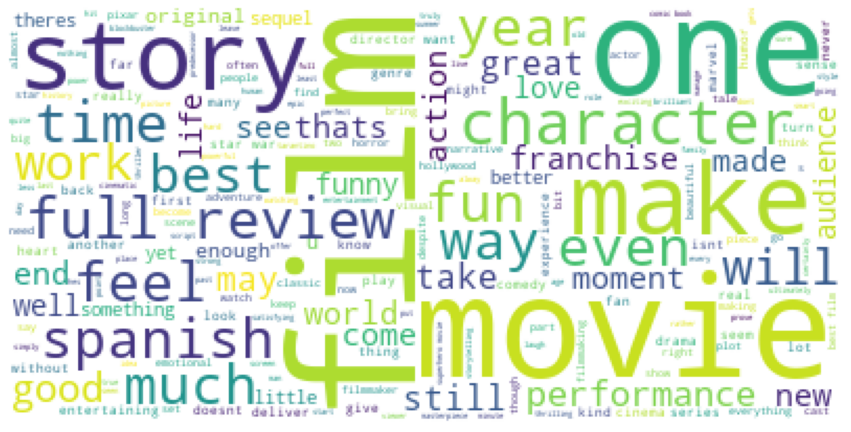

In [33]:
docs_strings = ' '.join(doc)
len(docs_strings)
wc2 =  WordCloud(background_color='white').generate(docs_strings)
plt.figure(figsize=[15,8])
plt.imshow(wc2)
plt.axis('off')

# Scaling of the Rating

In [34]:
def rating(var):
    rating_score = []
    for i in var:
        j = str(i)
        re1 = re.findall(r'[-+]?\d*\.\d+|\d+',i)
        temp = round(((float(re1[0])/float(re1[1]))*100)*.05,0)
        rating_score.append(temp)
    return rating_score

In [35]:
df_review['Overall'] = rating(df_review['Rating'])

In [36]:
df_review.Overall.unique()

array([2., 4., 1., 0., 3., 5.])

In [37]:
df_review.Overall.replace({0:'negative',1:'negative',2:'negative'
                      ,3:'neutral',4:'positive',5:'positive'},inplace=True)

# Simple Text Supervised Classification Model Fitting

In [38]:
data = df_review[df_review['Overall']!='neutral']
data = data.reset_index(drop=True)

In [120]:
stemmer = PorterStemmer()
docs = data['Review'].str.lower().str.replace('[^a-z\s]', '')
docs = docs.apply(remove_stopwords)  # stopword are removed
docs = stemmer.stem_documents(docs)

In [121]:
# splitting into train and test
train_docs, test_docs = train_test_split(pd.Series(docs), test_size=0.2, random_state=1)
print(f'Shape of Train: {train_docs.shape}')
print(f'Shape of Test: {test_docs.shape}')

Shape of Train: (38465,)
Shape of Test: (9617,)


In [122]:
# labels
train_y = data.loc[train_docs.index,'Overall']
test_y = data.loc[test_docs.index,'Overall']
print(f'Shape of Y-Train: {train_y.shape}')
print(f'Shape of Y-Test: {test_y.shape}')

Shape of Y-Train: (38465,)
Shape of Y-Test: (9617,)


In [125]:
vectorizer = TfidfVectorizer(min_df=5).fit(train_docs)
train_dtm = vectorizer.transform(train_docs)
test_dtm = vectorizer.transform(test_docs)
naive_bayes_model = MultinomialNB().fit(train_dtm, train_y)
test_y_pred = naive_bayes_model.predict(test_dtm)
print('Accuracy Score :',accuracy_score(test_y,test_y_pred))
print('F1 Score :',f1_score(test_y,test_y_pred,pos_label='positive'))

Accuracy Score : 0.9017365082666112
F1 Score : 0.948056944978838


# Sentiment Analysis using Word Embeddings

## Tokenization

In [134]:
data2 = data.copy()  # creating a copy

In [136]:
data2['Overall'] = data2['Overall'].replace({'negative': 0, 'positive': 1})  # #converting rating into 0 and 1
print(data2.shape)
data2.head()

(48082, 4)


,Rating,Review,Title,Overall
0,1.5/4,...it unfurls more like an M. Night Shyamalan ...,infinite,0
1,1.8/4,This action film about reincarnation tries to ...,infinite,0
2,7/10,Infinite boasts a high-concept story and extre...,infinite,1
3,2/4,I'll give points for finely crafted action seq...,infinite,0
4,2/4,"It's exactly the kind of big, silly, occasiona...",infinite,0


In [137]:
docs = data2['Review'].str.replace('[^a-zA-Z\s]', '')  # taking only the word columns
docs.head()

0    it unfurls more like an M Night Shyamalan scif...
1    This action film about reincarnation tries to ...
2    Infinite boasts a highconcept story and extrem...
3    Ill give points for finely crafted action sequ...
4    Its exactly the kind of big silly occasionally...
Name: Review, dtype: object

In [138]:
# splitting datapoint to train and test
train_x, test_x, train_y, test_y = train_test_split(pd.Series(docs), data2['Overall'] ,test_size=0.2, random_state=1)
print(f'Shape of Train_X {train_x.shape}')
print(f'Shape of Train_y {train_y.shape}')
print(f'Shape of Test_X {test_x.shape}')
print(f'Shape of Test_y {test_x.shape}')

Shape of Train_X (38465,)
Shape of Train_y (38465,)
Shape of Test_X (9617,)
Shape of Test_y (9617,)


In [139]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)  # all the unique vocabulary
vocal_size = len(tokenizer.word_index)+1
print(f'Number of Unique Word: {vocal_size}')

Number of Unique Word: 35548


In [141]:
train_x_seq =tokenizer.texts_to_sequences(train_x) # for each of the word it will assign corresponding index

In [142]:
# for test set we need to tokenizer
test_x_seq = tokenizer.texts_to_sequences(test_x)

In [ ]:
# finding optimal length of document
docs_size = []
for doc in train_x_seq:
    docs_size.append(len(doc))
pd.Series(docs_size).plot.box()

In [144]:
train_x_padded =  pad_sequences(train_x_seq,padding='post',maxlen=20)  
# here padding post mean the padding is happening at the end and can be done at beginning also.
# here maxlen is a particular document size should be as a particular size.
train_x_padded[0]

array([ 176,    3,  150,    2,  835,   19,    4,    1,   31,    4,    1,
        109,    3,    2,  158, 1940,   15,    1, 2171, 1328])

In [147]:
test_x_padded = pad_sequences(test_x_seq,padding='post',maxlen=20) 

## Creating embedding matrix for only required word 

In [167]:
# using google news word embedding
embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [168]:
print(f'Number of Words in Google News Word Embedding: {len(embeddings)}')

Number of Words in Google News Word Embedding: 3000000


In [169]:
words_not_available = []
for word, wid in tokenizer.word_index.items():
    if word not in embeddings:
        words_not_available.append(word)

In [170]:
print(f'Percentage of value not in the Google Word embedding: {round(len(words_not_available)/vocal_size *100,2)}')

Percentage of value not in the Google Word embedding: 26.02


In [171]:
# using wiki_new word embedding
wiki_news_vector = {}
file = open('wiki-news-300d-1M.vec',encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    wiki_news_vector[word] = vectors
file.close()

In [172]:
print(f'Number of Words in Wiki News Word Embedding: {len(wiki_news_vector.keys())}')

Number of Words in Wiki News Word Embedding: 999995


In [173]:
words_not_available = []

for word, wid in tokenizer.word_index.items():
    if word not in wiki_news_vector.keys():
        words_not_available.append(word)

In [174]:
print(f'Percentage of value not in the Wiki News Word embedding: {round(len(words_not_available)/vocal_size *100,2)}')

Percentage of value not in the Wiki News Word embedding: 23.98


In [175]:
# using glove word embedding
glove_vectors = dict()
file = open('glove.6B.300d.txt',encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors
file.close()

In [176]:
print(f'Number of Words in Glove Word Embedding: {len(glove_vectors.keys())}')

Number of Words in Glove Word Embedding: 400000


In [179]:
subset_embedding_matrix = np.zeros((vocal_size,300))
words_available = []
words_not_available = []

for word, wid in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        subset_embedding_matrix[wid] = glove_vectors[word]
        words_available.append(word)
    else:
        words_not_available.append(word)

In [180]:
print(f'Percentage of value not in the Glove Word embedding: {round(len(words_not_available)/vocal_size *100,2)}')

Percentage of value not in the Glove Word embedding: 23.33


In [181]:
print(f'Shape of Embedding Matrix: {subset_embedding_matrix.shape}')

Shape of Embedding Matrix: (35548, 300)


## Model Building

In [47]:
def plot_graphs(history, string):   # function for plotting graph
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [182]:
embedding_dim = 300
model = Sequential()
model.add(layers.Embedding(vocal_size, embedding_dim,
                          weights = [subset_embedding_matrix],
                          input_length=20,
                          trainable=False))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
early_stopping = EarlyStopping(min_delta = 0.01,
                               mode = 'max',
                               monitor = 'val_loss',
                               patience = 5)
callback = [early_stopping]

In [195]:
history = model.fit(train_x_padded, train_y, epochs=20,batch_size=64,validation_data=(test_x_padded,test_y),callbacks=callback)

Epoch 1/20
602/602 [==============================] - 4s 7ms/step - loss: 0.3157 - accuracy: 0.9006 - val_loss: 0.3262 - val_accuracy: 0.8972
Epoch 2/20
602/602 [==============================] - 4s 7ms/step - loss: 0.3158 - accuracy: 0.9006 - val_loss: 0.3259 - val_accuracy: 0.8973
Epoch 3/20
602/602 [==============================] - 5s 8ms/step - loss: 0.3157 - accuracy: 0.9006 - val_loss: 0.3261 - val_accuracy: 0.8972
Epoch 4/20
602/602 [==============================] - 3s 5ms/step - loss: 0.3157 - accuracy: 0.9006 - val_loss: 0.3257 - val_accuracy: 0.8973
Epoch 5/20
602/602 [==============================] - 5s 9ms/step - loss: 0.3158 - accuracy: 0.9006 - val_loss: 0.3257 - val_accuracy: 0.8972
Epoch 6/20
602/602 [==============================] - 4s 6ms/step - loss: 0.3155 - accuracy: 0.9006 - val_loss: 0.3291 - val_accuracy: 0.8973


In [196]:
loss = model.evaluate(test_x_padded, test_y)

301/301 [==============================] - 2s 7ms/step - loss: 0.3291 - accuracy: 0.8973


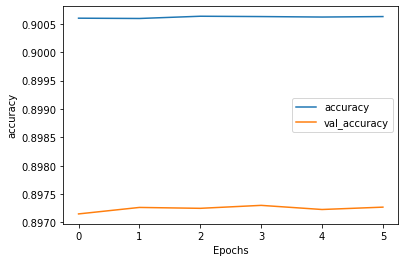

In [199]:
plot_graphs(history,'accuracy')

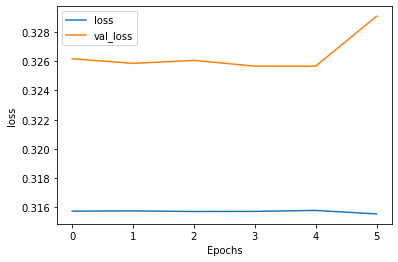

In [200]:
plot_graphs(history,'loss')

# LSTM Model

In [39]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data['Review'] = data['Review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Review'].values)
vocal_size = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(data['Review'].values)
X = pad_sequences(X)

In [40]:
print(f'Number of words: {vocal_size}')

Number of words: 40047


In [41]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocal_size, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
# model.summary()

In [42]:
Y = pd.get_dummies(data['Overall']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')

Shape of X_train: (40869, 51)
Shape of Y_train: (40869, 2)
Shape of X_test: (7213, 51)
Shape of Y_test: (7213, 2)


In [54]:
batch_size = 32
history = model.fit(X_train,Y_train,epochs =5,batch_size=batch_size,validation_data=(X_test,Y_test),callbacks=callback)

Epoch 1/5
1278/1278 [==============================] - 212s 166ms/step - loss: 0.1591 - accuracy: 0.9442 - val_loss: 0.3207 - val_accuracy: 0.8673
Epoch 2/5
1278/1278 [==============================] - 210s 164ms/step - loss: 0.1558 - accuracy: 0.9479 - val_loss: 0.3089 - val_accuracy: 0.8890
Epoch 3/5
1278/1278 [==============================] - 194s 152ms/step - loss: 0.1473 - accuracy: 0.9503 - val_loss: 0.3096 - val_accuracy: 0.8923
Epoch 4/5
1278/1278 [==============================] - 196s 154ms/step - loss: 0.1432 - accuracy: 0.9522 - val_loss: 0.3362 - val_accuracy: 0.8704
Epoch 5/5
1278/1278 [==============================] - 204s 160ms/step - loss: 0.1350 - accuracy: 0.9566 - val_loss: 0.3605 - val_accuracy: 0.8605


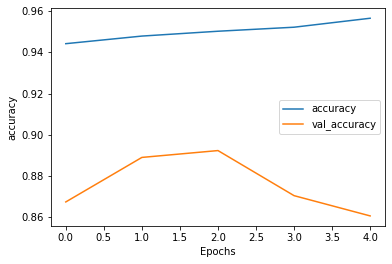

In [55]:
plot_graphs(history,'accuracy')

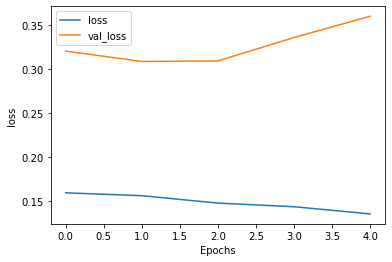

In [56]:
plot_graphs(history,'loss')

# Prediction

In [60]:
def prediction():
    count=0
    while(count==0):
        movie_name = input('Enter the Movie Name: ')
        l1 = list(df_movie.Title)
        if movie_name in l1:
            count=1
            break
        else:
            print('Movie Not Available')
       
    review = input('Enter the review for the movie'+' '+movie_name+':')
    twt = [review]
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=51, dtype='int32', value=0)
    sentiment = model.predict(twt)
    flag=0
    if(np.argmax(sentiment) == 0):
        print("negative")
        flag=0
    elif (np.argmax(sentiment) == 1):
        print("positive")
        flag=1
    if flag==1:
        genre = list(df_movie[df_movie['Title']==movie_name]['Main Genre'])[0]
        print(genre)
        recommendation = list(df_movie[df_movie['Main Genre']==genre]['Title'])[:10]
    else:
        recommendation = 'No Recommendation'
    return recommendation

In [61]:
similar_genre_movie = prediction()
print('Similar Movie in this Genre: ',similar_genre_movie)

Enter the Movie Name: dart
Movie Not Available
Enter the Movie Name: wonder woman 2017
Enter the review for the movie wonder woman 2017:this is a good movie!
positive
action
Similar Movie in this Genre:  ['infinite', 'skyfall', 'mission impossible ghost protocol', 'star trek beyond', 'gunpowder milkshake', 'die in a gunfight', 'f9', 'the forever purge', 'the hitmans wifes bodyguard', 'lucy 2014']


### Conclusion and Future Scope

- Webscrapped data from rotten tomatoes and got around 267 movie with overall 55k review.
- Built different model with LSTM giving best train and validation accuracy.
- Built a recommendation based on genre for a user input review for a particular movie.
- However the recommendation can be improved by recommending based on highest rating for that particular genre.
- Also autocomplete of text can be implemented for user input review.